In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from IPython import display

### Budget equation longitundnal momentum
The budget equation is given as:

$ \frac{\partial{<\overline{u}>}}{\partial{t}} = -C_d A(z) {<\overline{u}>}^2 -  \frac{\partial{<\overline{w' u'}>}}{\partial{z}}$

The funtion "budget_momentum", gets $<\overline{u}>(t=t_c,z)$, and $\frac{\partial{<\overline{w' u'}>}}{\partial{z}}(t=t_c, z)$ to compute $<\overline{u}>(t=t_c+dt,z)$

In [2]:
def budget_momentum(u, omega_u_dz):
    u_new = u + (- C_d * PAD * u ** 2 - omega_u_dz) * dt
    return u_new

### Budget equation for  a scalar
The budget equation for scalar $\xi$ is:

$ \frac{\partial{<\overline{\xi}>}}{\partial{t}} = S_{\xi} -  \frac{\partial{<\overline{w'\xi'}>}}{\partial{z}}$

The funtion "budget_xi", gets $<\overline{\xi}>(t=t_c,z)$, $\frac{\partial{<\overline{w'\xi'}>}}{\partial{z}}(t=t_c, z)$, and $S_{\xi}(t=t_c,z)$ and returns $<\overline{\xi}>(t=t_c+dt,z)$.

In [3]:
def budget_xi(xi, omega_xi_dz, S_xi):
    xi_new = xi + (S_xi - omega_xi_dz) * dt
    return xi_new

## Source term
The source term $S_{\xi}$ can be computed as:

$S_{\xi} = a(z) G_{\xi} \left(\left<\overline{\xi_L}\right> - \left<\overline{\xi}\right>\right)$

$G_{\xi} = g_{b,\xi} \ \ g_{s,\xi}$

In [4]:
def source_term(xi, xi_L, g_b_xi, g_s_xi, option):
    if option == 'T':
        S_xi = LAD * 1. / (1. / g_b_xi) * (xi_L - xi)
    if option == 'e':
        S_xi = LAD * 1. / (1. / g_b_xi + 1. / g_s_xi) * (xi_L - xi)
    return S_xi

## Conductances (boundry-level and stomotal)

$g_{b,\xi} = \nu_{\xi} \left(\frac{\left<\overline{u}\right>}{0.75 d} \right)^{0.5}$

$g_{s,\xi} = ... $

In [5]:
def boundry_layer_conductance(u, nu_xi):
    g_b_xi = nu_xi * np.sqrt(u / (0.75 * d))
    return g_b_xi

def rediation_assimilation(T_L, V_cmax_25, a_1, a_2, Gamma_star, C_i, kappa_1, kappa_2):
    V_cmax = V_cmax_25 * (np.exp(a_1 * (T_L - 25.))) / (1. + np.exp(a_2 * (T_L - 41.) ))
    R_d = Kai * V_cmax
    A_n = kappa_1 * (C_i - Gamma_star) / (C_i + kappa_2) - R_d
    return R_d, A_n

### First_order closure model
The first_order closure approximation for the turbulance flux in budget equation is:

$ <\overline{w'\xi'}> = -K_{\xi} \frac{\partial{<\overline{\xi}>}}{\partial{z}}$ and $ <\overline{w'u'}> = -K_{m} \frac{\partial{<\overline{u}>}}{\partial{z}}$

$K = L^2|\frac{\partial{<\overline{u}>}}{\partial{z}}|$

where $L=\alpha_{ml} h$ for $z<h$ and $k(z - d_0)$ otherwise. 

The funtion "first_order_closure" gets $\frac{\partial{<\overline{u}>}}{\partial{z}}(t=t_c,z)$, $\frac{\partial{<\overline{\xi}>}}{\partial{z}}(t=t_c,z)$, and other paramters to compute  $<\overline{w'\xi'}>(t=t_c,z)$. 

In [6]:
def first_order_closure(u, u_dz, xi_dz):
    d_0 = np.sum(z * u ** 2 * PAD) / np.sum(u ** 2 * PAD) 
    alpha_ml = k_c * (h_c - d_0) / h_c
    L = np.where(z < h_c, alpha_ml * h_c, k_c * (z - d_0))
    K = L ** 2 * np.abs(u_dz)
    omega_xi = -K * xi_dz
    omega_xi_dz = drevative(omega_xi)
    return omega_xi_dz

def drevative(u):
    u_1 = np.roll(u, -1)
    u_2 = np.roll(u, 1)
    u_dz = (u_1 - u_2) / (2 * dz)
    u_dz[0] = (u[1] - u[0]) / dz
    u_dz[-1] = (u[-1] - u[-2]) / dz
    return u_dz

## Javis stomatal conductance

In [7]:
def javis_stomatal_conductance(phi, T_a, sai_l, RH):
    f_phi = 1 - np.exp(-k_1 * phi)
    
    f_T_a = 1 - k_2 * (T_a - T_opt) ** 2
    
    if sai_l < sai_l_0:
        f_sai_l = 0.
    elif sai_l_0 <= sai_l and sai_l <= sai_l_1:
        f_sai_l = (sai_l - sai_l_0) / (sai_l_1 - sai_l_0)
    else:
        f_sai_l = 1.
    _, _, vpd = e_and_VPD(RH, T_a)
    f_D = 1. / (1 + vpd / D_x)
    g_s = g_s_max * f_phi * f_T_a * f_sai_l * f_D
    return g_s
    
def e_and_VPD(RH, T):
    e_sat = 611.71 * np.exp(2.501 / (.461*10**-3) * (1./273.15 - 1./T))
    e = RH / 100. * e_sat
    vpd = e_sat - e
    return e, e_sat, vpd

def RH_from_e(e, T):
    e_sat = 611.71 * np.exp(2.501 / (.461*10**-3) * (1./273.15 - 1./T))
    RH = e / e_sat * 100
    return RH

def e_at_leaf(sai_l, T_l, h):
    esat_l = 611.71 * np.exp(2.501 / (.461*10**-3) * (1./273.15 - 1./T_l))
    e_l = esat_l * np.exp(nuv * (sai_l - g * row_w * h) / R /T_l);
    return e_l

## Soil-root-plant conductance

In [8]:
def soil_plant_root_conductance(sai_l, LAI, s):
    RAI = RAIW * s ** (-a)
    L = 0.11574 * K_s * s ** (2. * b + 3.)
    g_sr = (L * np.sqrt(RAI) * 10 ** 6) / (np.pi * g * row_w * Z_r)
    g_p = g_p_max * np.exp(-(-sai_l/ d_1) ** c)
    g_srp = (LAI * g_sr * g_p) / (g_sr + LAI * g_p)
    return g_srp

## Nonlinear solver

In [9]:
def solver_objective(x, s, RH, T_a, p0, phi, nu_e, u, LAI):
    sai_l = x[0]
    T_l = x[1]
    
    sai_s = sai_s_s * s ** (-b)
    g_a = boundry_layer_conductance(u, nu_e)
    g_s = javis_stomatal_conductance(phi, T_a, sai_l, RH)
    g_sa = (g_a * g_s) / (g_a + g_s)
    g_srp = soil_plant_root_conductance(sai_l, LAI, s)
    
    e_a, e_sat_a, _ = e_and_VPD(RH, T_a)
    esat_l = 611.71 * np.exp(2.501 / (.461*10**-3) * (1./273.15 - 1./T_l))
    e_l = esat_l * np.exp(nuv * (sai_l - g * row_w * h_c) / R /T_l);
    
    E_1 = g_srp * (sai_s - sai_l) * 10 ** (-3) * 24. * 3600.
    E_2 = g_sa * 0.622 / p0 * (e_l - e_a) * row / row_w * 24. * 3600.
    E_3 = (phi - row * c_p * g_a * 10**(-3) * (T_l - T_a)) / (row_w * lambda_w) * 1000 * 24 * 3600 
    
    diff = np.abs(E_1 - E_2) + np.abs(E_1 - E_3)
    return diff

## Inputs

In [12]:
## Global physical
global g, row_w, nuv, R, lambda_w, c_p
g = 9.8
row_w = 1000.
nuv = 18. / (1000. * row_w)
R = 8.314
row = 1.225
c_p = 1005
lambda_w = 2.45 * 10 ** 6

# ## Global variables related to atmospheric conductance
# global U_w, k, h_c, d, z_o, z_oq
# U_w = 5.
# 
# k = 0.41
# d = 0.7 * h_c
# z_o = d / 10.
# z_oq = 0.2 * z_o

## Global variables related to atmospheric conductance
global nu_T, nu_e ,d
d = 0.15
nu_T = 3. # mm/s^0.5
nu_e = 3. # mm/s^0.5

## Global variables related to stomatal conductance
global g_s_max, k_1, k_2, T_opt, sai_l_0, sai_l_1, D_x
g_s_max = 25 # mm/s
k_1 = 0.005 # m^2/W
k_2 = 0.0016 # 1/K it should be 1/K^2 double check
T_opt = 298. # K
sai_l_0 = -4.5 # MPa
sai_l_1 = -0.05 #MPa
D_x = 1250. #Pa

## Global variables related to soil-root-plant conductance
global g_p_max, a, b, c, d_1, RAIW, Z_r, LAI, sai_s_s, K_s
g_p_max = 11.7
a = 8.
b = 5.39
c = 2.
d_1 = 2.
Z_r  = 0.6
RAIW = 5.
sai_s_s = -1.43 * 10 ** (-3)
K_s = 20.


## Global related to the turbulance simulation
global h_c, dz, dt, C_d, PAD, LAD, N_z, k, z
h_c = 20. # m
dz = 2. # m
dt = 1. # s
C_d = 0.2 
N_z = int(h_c / dz)
LAD = np.ones(N_z) * 0.2 # m^2 / m^3
PAD = np.ones(N_z) * 0.3 # m^2 / m^3
k_c = 0.4
z = np.arange(0, N_z) * dz + 1.

## Simulation model

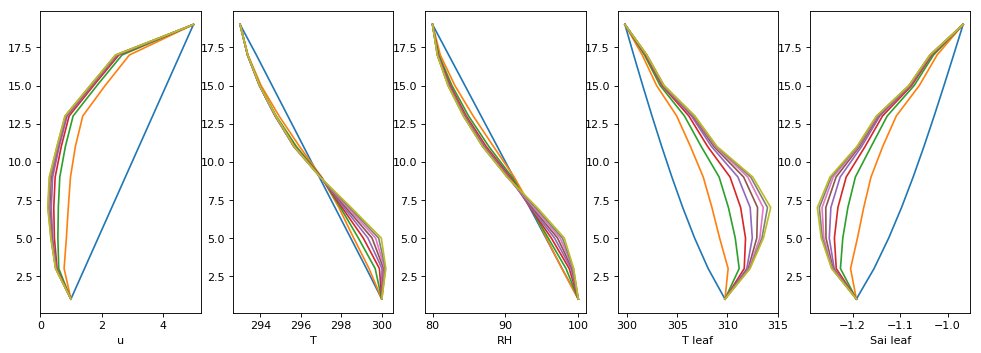

 time =  81 time =  82 time =  83 time =  84 time =  85 time =  86

In [ ]:
p0 = 101.325 * 10 ** 3
s = 0.45
phi = 400.
inital_T = 293.
initial_RH = 0.5
u_hc = 5. 


T = np.arange(0, N_z) * (293. - 300.) / float(N_z - 1) + 300.
RH = np.arange(0, N_z) * (80. - 100.) / float(N_z - 1) + 100.
T_L = np.zeros(N_z)
e_L = np.zeros(N_z)
e = np.zeros(N_z)
for i in range(0, N_z):
    e[i], _, _ = e_and_VPD(RH[i], T[i])
sai_L = np.zeros(N_z)    
u = np.arange(0, N_z) * (5. - 1.) / float(N_z - 1) + 1.
g_s_e = np.zeros(N_z)
g_s_T = np.zeros(N_z)
g_b_e = np.zeros(N_z)
g_b_T = np.zeros(N_z)

fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

for time in range(0, 100):
    print 'time = ', time ,
    u_dz = drevative(u)
    omega_u_dz = first_order_closure(u, u_dz, u_dz)
    u_new = budget_momentum(u, omega_u_dz)
    u_new[0] = 1.
    u_new[-1] = 5.
    

    bounds = [(-3, 0), (320, 290)]
    for i in range(0, N_z):
        result = differential_evolution(solver_objective, bounds, args=(s, RH[i], T[i], p0, phi, nu_e, u[i], LAD[i] * dz))
        T_L[i] = result.x[1]
        sai_L[i] = result.x[0]
        e_L[i] = e_at_leaf(sai_L[i], T_L[i], z[i])
        g_s_e[i] = javis_stomatal_conductance(phi, T[i], sai_L[i], RH[i]) * 10 ** -3
        g_s_T[i] =  0.
        g_b_e[i] = boundry_layer_conductance(u[i], nu_e) * 10 ** -3
        g_b_T[i] = boundry_layer_conductance(u[i], nu_T) * 10 ** -3
        #print RH[i], T_L[i], sai_L[i], result.fun

    S_T = source_term(T, T_L, g_b_T, g_s_T, 'T')
    S_e = source_term(e, e_L, g_b_e, g_s_e, 'e')

    T_dz = drevative(T)
    omega_T_dz = first_order_closure(u, u_dz, T_dz)
    T_new = budget_xi(T, omega_T_dz, S_T)
    T_new[-1] = 293.
    T_new[0] = 300.


    e_dz = drevative(e)
    omega_e_dz = first_order_closure(u, u_dz, e_dz)
    e_new = budget_xi(e, omega_e_dz, S_e)
    e_new[0], _, _  = e_and_VPD(100, T_new[0])
    e_new[-1], _, _ = e_and_VPD(80, T_new[-1])
    
    e = e_new
    T = T_new
    
    if time % 10 == 0:
       
        plt.subplot(151)
        plt.plot(u, z)
        plt.xlabel('u')
        plt.subplot(152)
        plt.plot(T, z)
        plt.xlabel('T')
        plt.subplot(153)
        plt.plot(RH, z)
        plt.xlabel('RH')
        plt.subplot(154)
        plt.plot(T_L, z)
        plt.xlabel('T leaf')
        plt.subplot(155)
        plt.plot(sai_L, z)
        plt.xlabel('Sai leaf')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    u = u_new
    
    for i in range(0, N_z):
        RH[i] = RH_from_e(e[i], T[i])